# Notebook for RDE analysis
Primarily for Pt based catalysts.

### 1. Initialization.

In [1]:
%load_ext autoreload
from analysis_CV import *
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox
import os

root = tk.Tk()
root.withdraw()
root.lift()
root.attributes("-topmost", True)

''

### 2. Choose folder with the data files to be analyzed.
Later you have the choice to pick one or several of the files in the folder to analyze.

In [2]:
path = filedialog.askdirectory()

#### 2.A Analysis of one file: Open the file with the interesting voltage and current data.
See analysis_CV.py for more information about the functions.

In [3]:
%autoreload
nbr_files = 1
file = filedialog.askopenfilename()
V, I = get_voltage_current(file, 10)
print(file)

C:/Users/go29guw/Documents/Data analysis/2024_01_09/ML02 CV/ML02_M012_Cyc0003.txt


#### 2.B Analysis of several files: Open the files with the interestig voltage and current data.

In [3]:
nbr_files = 2
files = filedialog.askopenfilenames(title="Open the files to analyze.")
data_matrix = []

for file in files: 
    V_i, I_i = get_voltage_current(file, 10)
    data_matrix.append(V_i)
    data_matrix.append(I_i)

data_matrix = np.transpose(data_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]
print(files)

('C:/Users/go29guw/Documents/Data analysis/2024_01_08/ML00/ML00_M003_Cyc0036.txt', 'C:/Users/go29guw/Documents/Data analysis/2024_01_08/ML00/ML00_M010_Cyc0050.txt')


### 3. Introduce background and parameters: choose the corresponding files.

In [13]:
%autoreload
background_file = filedialog.askopenfilename()
background_matrix = get_background(background_file, 10)

In [4]:
parameters_file = filedialog.askopenfilename()
parameters_dictionary = get_parameters(parameters_file)

### 4. Corrections.
The following corrections can be made:
* Adjusting voltage to RHE potential.
* iR-drop correction
* Background adjustment of current

In [6]:
%autoreload
background_RHE = RHE_correction_background(background_matrix, parameters_dictionary)

if nbr_files == 1:
    voltage_RHE = RHE_correction(V, parameters_dictionary)
    new_V = ir_drop_correction(voltage_RHE, background_RHE, parameters_dictionary)
    new_I = background_correction_current(I, background_RHE)
else:
    for i in range(len(data_matrix[0])):
        if i % 2 == 0:  #voltage are stored in even indexed columns
            data_matrix[:,i] = RHE_correction(data_matrix[:,i], parameters_dictionary)
            data_matrix[:,i] = ir_drop_correction(data_matrix[:,i], background_RHE, parameters_dictionary)
        # else:  #current
        #     data_matrix[:,i] = background_correction_current(data_matrix[:,i], background_RHE)
    data_matrix[:,3] = background_correction_current(data_matrix[:,3], background_RHE)
    

In [7]:
len(background_matrix)

2280

### 5. Normalizing to geometric surface area and mass.

In [5]:
%autoreload
if nbr_files == 1:
    mass_I = copy.deepcopy(I)
    surface_I = copy.deepcopy(I)

    mass_I, surface_I = normalizing(I, parameters_dictionary)
else:
    mass_matrix = copy.deepcopy(data_matrix)
    surface_matrix = copy.deepcopy(data_matrix) 

    for i in range(len(data_matrix[0])):
        if i % 2 != 0:  
            mass_matrix[:,i], surface_matrix[:,i] = normalizing(data_matrix[:,i], parameters_dictionary)
    

### 6. Plotting

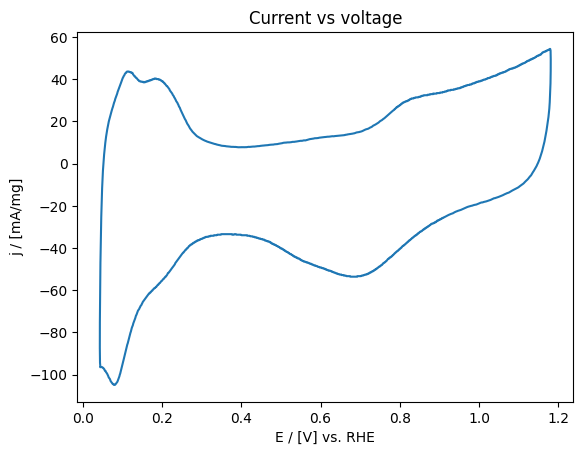

In [10]:
if nbr_files == 1:
    plt.plot(voltage_RHE, mass_I)
    plt.xlabel('E / [V] vs. RHE')
    plt.ylabel('j / [mA/mg]')
    plt.title('Current vs voltage')
else:
    for i in range(0,len(data_matrix[0]),2):
        plt.plot(mass_matrix[:,i],mass_matrix[:,i+1])
    plt.xlabel('E / [V] vs. RHE')
    plt.ylabel('j / [mA/mg]')
    #plt.legend(["Curve", "O2"])
    plt.title('Current vs voltage')

### 7. Analysis.
Determining ECSA etc.

ECSA: 5.803009278164815 mA*V/mg


Text(0.5, 1.0, 'Current vs voltage')

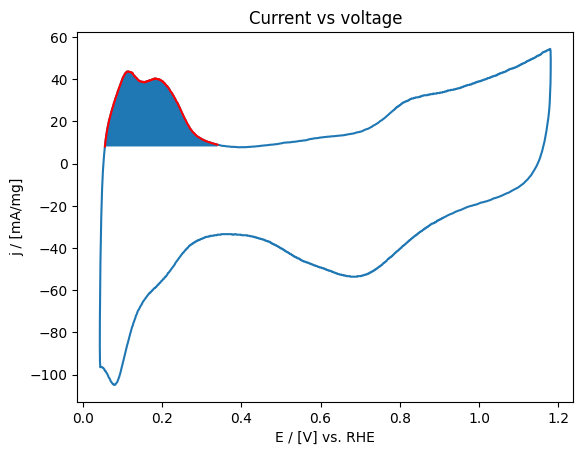

In [13]:
# Choose x-region to look at the ECSA (HUP, CO stripping peak)
lower_limit = 0.055
upper_limit = 0.34

# voltage = list(copy.deepcopy(data_matrix[:,2])) #Choose which CV to look at. list to be able to use index() method
# current = list(copy.deepcopy(data_matrix[:,3])) 
voltage = copy.deepcopy(voltage_RHE)
current = copy.deepcopy(mass_I)

integration_start = next(x for x in voltage if x >= lower_limit)
integration_end = next(x for x in voltage if x >= upper_limit)

integration_interval = slice(voltage.index(integration_start), voltage.index(integration_end))
height = current[voltage.index(integration_start)]
ECSA = np.trapz(current[integration_interval], voltage[integration_interval]) - height * (upper_limit - lower_limit)
print('ECSA:', ECSA, 'mA*V/mg')

plt.plot(voltage, current)
plt.plot(voltage[integration_interval], current[integration_interval], 'red')
plt.fill_between(voltage[integration_interval], current[integration_interval], height)
plt.xlabel('E / [V] vs. RHE')
plt.ylabel('j / [mA/mg]')
plt.title('Current vs voltage')